# Chest X-Ray Image Classification Using Tranfer Learning

## Preliminary

The objective of this project is to classify images of chest x-rays into three classes: Normal, COVID-19, and Pneumonia. Classification was performed using transfer learning by implementing the Inception V3 and ResNet 101 V2 architectures.

A practical use of these models would be for medical clinicians to analyze chest x-rays to diagnose Pneumonia or COVID-19. As such, we would want a model that errs on the side of having more false positives than false negatives. You would not want a situation where a clinician indicates there is no illness when indeed there is one. Such could cause the clinician to refuse to prescribe treatment when treatment is needed. On the other hand, a false-positive diagnosis has less risks associated with it. Therefore preference will be given to models that minimize false negatives.

The image data was  pulled from multiple sources and compiled by Kaggle user, JPTIPTJ. <br>
https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis

The data provided from the source above also included chest x-rays for a TUBERCULOSIS class. The TUBERCULOSIS images had far more distortions and inconsistencies than the images for the other classes. The below images show examples of the PNEUMONIA data and the TUBERCULOSIS data. The PNEUMONIA image is close to black and white and shows a great amount of detail. The TUBERCULOSIS data, on the other hand, has inconsistencies with cropping, with contrast, and with color balance. Most concerning, however, is that most images in this class have white boxes in diverse locations. This strongly biases the data in that a model may simply learn to classify any image with a white box as TUBERCULOSIS without learning the nuances of the x-ray itself.

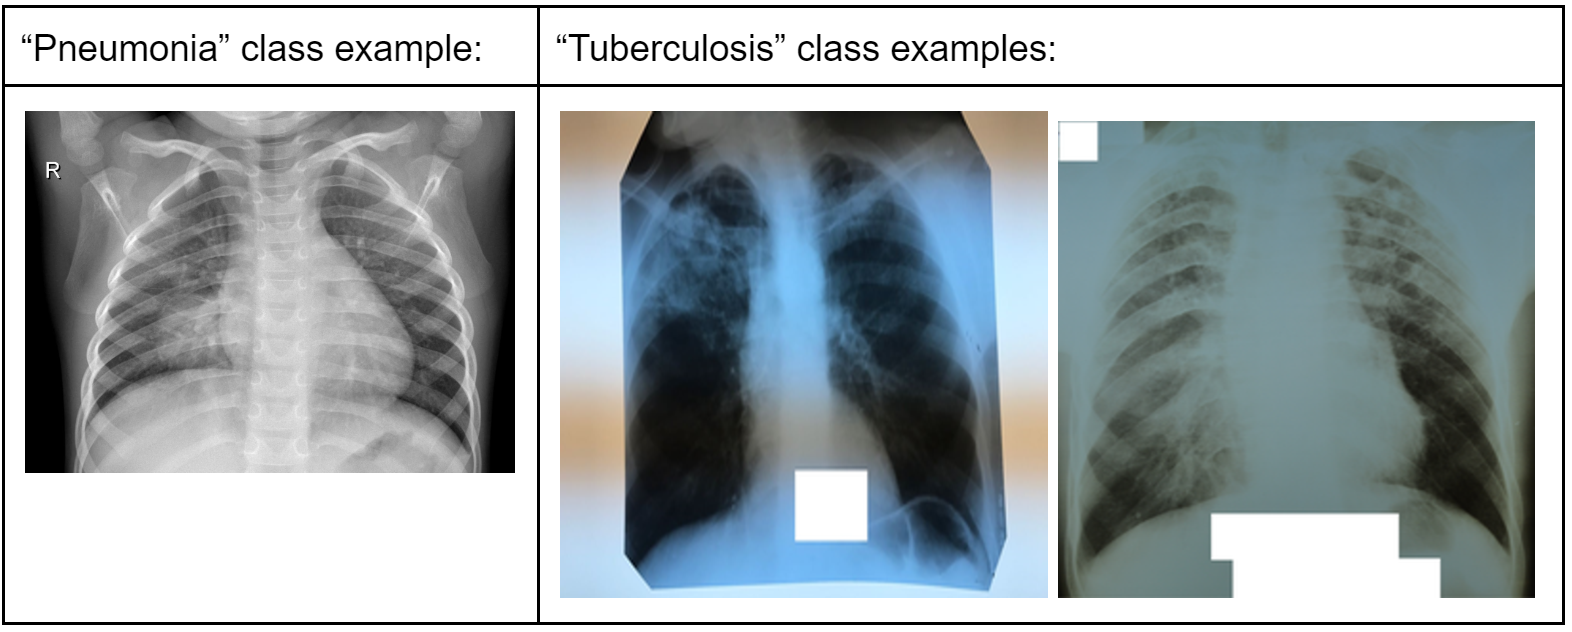

In [1]:
from PIL import Image
Image.open("tb_issue.png")

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

In [3]:
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras import Input, Model, initializers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_input_Inc
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as MN_preprocess
from tensorflow.keras.applications.resnet_v2 import ResNet101V2, preprocess_input as ResNet_preprocess
from tensorflow.image import crop_and_resize

### Define Functions

In [4]:
seed=531

In [5]:
#Early Stopping with Patience=3
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

#Early Stopping with Patience=5
earlystop_5 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [6]:
#F1 score
def f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [7]:
#Reset Weights
def reset_weights(model):
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and \
                hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=old_biases.shape)]) 

In [8]:
#History Plot
def history_plot(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(8, 4))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Categorical Cross Entropy')
    #plt.yscale('log')
    plt.ylim(bottom=0)
    #plt.yticks(ticks=[0,1,2,3,4,5,6], labels=[0,1,2,3,4,5,6])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.xticks(np.arange(30))
    plt.show()

In [9]:
#Confusion Matix Heat Map
def print_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred)
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d')
    

## Load Data

### Determine Shape of Images

In [10]:
single_image = load_img('chestxraydata/train/COVID19/COVID19(0).jpg')
single_image_arr = img_to_array(single_image)
single_image_arr.shape

(2000, 2000, 3)

### Load images & Augment training data

The image data was already split into Test and Train datasets, with 730 images in Test and 5,676 images in Train. I imported the data and performed the following data augmentation:
- Rescale the images
    - 256x256x3 pixels for Inception and ResNet
    - 224x224x3 pixels for MobileNet (as these specific dimensions are required by the model)
- Random rotation of ≤ 5°
- Random shear intensity of ≤ 5°
- Random hight shift of ≤ 15%
- Random width shift of ≤ 15%
- Random zoom between 90% and 110%
- Random brightness adjustment between 80% and 120%
- Random horizontal flip
- Fill mode = ‘constant’


#### For Inception and ResNet
Image size (256x256)

In [11]:
datagen_train = ImageDataGenerator(
    rescale=1/255,
    rotation_range=5,
    shear_range=5,
    height_shift_range=0.15,
    width_shift_range=0.15,
    zoom_range=[0.9, 1.1],
    brightness_range=[0.8, 1.2],
    fill_mode='constant',
    horizontal_flip=True,
    validation_split=0,
    dtype='float32'
)

generator_train = datagen_train.flow_from_directory(
    directory='chestxraydata/train',
    target_size=(256,256),
    batch_size=32, 
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=seed,
    save_to_dir='chestxraydata/augmented_train'
)

datagen_test = ImageDataGenerator(
    rescale=1/255,
    validation_split=0,
    dtype='float32'
)

generator_test = datagen_test.flow_from_directory(
    directory='chestxraydata/test',
    target_size=(256,256),
    batch_size=32, 
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 5676 images belonging to 3 classes.
Found 730 images belonging to 3 classes.


In [12]:
cls_train = generator_train.classes
cls_test = generator_test.classes
class_names = list(generator_train.class_indices.keys())
num_classes = generator_train.num_classes

### Determine class weights for imbalanced classes

The classes in the training data are imbalanced with 460 in the COVID19 class, 1,341 in the NORMAL class, and 3,875 in the PNEUMONIA class. Therefore, I assigned weights to the three classes respectively 4.11, 1.41, and 0.49.

In [13]:
print(np.unique(cls_train, return_counts=True))
print(np.unique(cls_test, return_counts=True))

(array([0, 1, 2]), array([ 460, 1341, 3875], dtype=int64))
(array([0, 1, 2]), array([106, 234, 390], dtype=int64))


In [14]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

class_weight=dict(zip(range(0,3),class_weight))

In [15]:
print(f'Number of Classes: {num_classes}')
print(f'Class Names: {class_names}')
print(f'Class Weights: {class_weight}')

Number of Classes: 3
Class Names: ['COVID19', 'NORMAL', 'PNEUMONIA']
Class Weights: {0: 4.113043478260869, 1: 1.4108873974645786, 2: 0.488258064516129}


## Inception V3 Model

### Base Model

The first framework I used for transfer learning was Inception V3. I imported the “imagenet” weights for the model and set include_top to “False” as I would be adding subsequent layers to the top. For the first round of training, I froze the layers from the base model so I could train only the final layers I would be adding myself.

In [16]:
base_model_Inc = InceptionV3(
    input_shape=(256,256,3), 
    weights='imagenet', 
    include_top=False
    )

base_model_Inc.trainable = False

### Preprocess

In [17]:
inputs_Inc = Input(shape=(256, 256,3))

inputs_p_Inc = preprocess_input_Inc(inputs_Inc)

### Add output layers & Compile

Starting with the base model, I added the following layers to the end:
- Global Average Pooling 2D - A faster, more robust method than a standard fully-connected layer
- Dropout (set to 50%) - Used to reduce the potential for overfitting. Perhaps an unnecessary layer in this case given that Global Average Pooling already reduces overfitting.
- Dense - Final layer using a softmax classifier

To compile the model, I selected the “Adam” optimizer using the default 0.001 learning rate. The loss function used was categorical crossentropy. I also created a function to be able to track the f1 metric of each step of the model.

In [18]:
base_Inc = base_model_Inc(inputs_p_Inc, training=False)
GAP_Inc = GlobalAveragePooling2D()(base_Inc)
drop_Inc = Dropout(0.5)(GAP_Inc)

output_Inc = Dense(num_classes, activation='softmax')(drop_Inc)
model_Inc = Model(inputs_Inc, output_Inc)

In [19]:
model_Inc.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=[f1])

The model summary below indicates there are 21,802,784 parameters in the base Inception V3 model, and 6,147 trainable parameters in the final layer.

In [20]:
model_Inc.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                

### Fit model

#### Fit

In [88]:
#reset_weights(model_Inc)

In [21]:
csv_log_Inc = CSVLogger('training_Inc.log', separator=',', append=False)

I fit the model for 30 epochs and a batch size of 128. I also established an early stopping trigger when the validation loss function does not improve after five epochs. If early stopping is triggered, the model will use the weights from the epoch with the lowest validation loss. Once fitting was complete, this model achieved a validation loss of 0.5618 and a validation f1 score of 0.8046.

In [25]:
model_Inc_history = model_Inc.fit(
    generator_train, 
    epochs=30, 
    batch_size=128,
    class_weight=class_weight, 
    validation_data=generator_test,
    callbacks=[earlystop_5, csv_log_Inc], 
    verbose=1)

Epoch 1/30
178/178 [==============================] - 656s 4s/step - loss: 1.0133 - f1: 0.1687 - val_loss: 0.8850 - val_f1: 0.2103
Epoch 2/30
178/178 [==============================] - 728s 4s/step - loss: 0.9007 - f1: 0.3209 - val_loss: 0.8497 - val_f1: 0.4487
Epoch 3/30
178/178 [==============================] - 700s 4s/step - loss: 0.8454 - f1: 0.4061 - val_loss: 0.7739 - val_f1: 0.6428
Epoch 4/30
178/178 [==============================] - 693s 4s/step - loss: 0.7927 - f1: 0.4573 - val_loss: 0.7449 - val_f1: 0.6656
Epoch 5/30
178/178 [==============================] - 738s 4s/step - loss: 0.7874 - f1: 0.4677 - val_loss: 0.7146 - val_f1: 0.6845
Epoch 6/30
178/178 [==============================] - 761s 4s/step - loss: 0.7678 - f1: 0.5107 - val_loss: 0.7962 - val_f1: 0.4634
Epoch 7/30
178/178 [==============================] - 753s 4s/step - loss: 0.7614 - f1: 0.5156 - val_loss: 0.6652 - val_f1: 0.7010
Epoch 8/30
178/178 [==============================] - 747s 4s/step - loss: 0.7485 -

In [26]:
model_Inc.save('tmp/saved_models/Inception_1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: tmp/saved_models/Inception_1\assets


In [22]:
model_Inc = load_model('tmp/saved_models/Inception_1', custom_objects={'f1':f1})

#### Plots

The plot below shows the training and validation loss over the 30 epochs. The plot indicates that training continued to improve throughout, though it flattened out in the end. It is worth noting that the training loss was consistently higher than the validation. This could potentially be due to the fact that the model was more challenged by the training data (where the images were augmented as detailed above) than it was by the test data where no augmentation was applied.

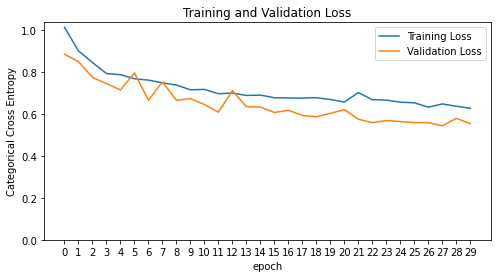

In [29]:
history_plot(model_Inc_history)

In [30]:
y_pred_Inc = model_Inc.predict(generator_test)
cls_pred_Inc = np.argmax(y_pred_Inc,axis=1)

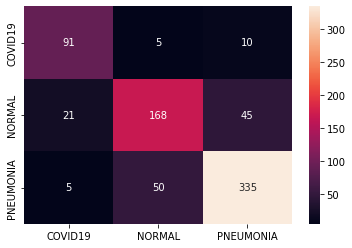

In [31]:
print_confusion_matrix(cls_pred_Inc)

### Fine-Tune Model

The next step was to fine-tune the model. I did so by unfreezing the layers of the base model. In addition I reduced the learning rate for the optimizer to ${10^{-5}}$.

#### Make Trainable

In [32]:
base_model_Inc.trainable = True

model_Inc_FT = model_Inc

model_Inc_FT.compile(loss='categorical_crossentropy',
                optimizer=Adam(1e-5),
                metrics=[f1])

#### Fit

The validation data stopped improving after epoch 7, therefore the early stopping was triggered after epoch 12. Because early stopping was triggered, the model reverted the weights back to those from the step in the training which had the lowest validation loss. This best validation loss is 0.3468, and its corresponding f1 score is 0.8569.

In [261]:
model_Inc_FT_history = model_Inc_FT.fit(
    generator_train, 
    epochs=30, 
    batch_size=128,
    class_weight=class_weight, 
    validation_data=generator_test,
    callbacks=[earlystop_5],
    verbose=1)

Epoch 1/30
178/178 [==============================] - 4033s 23s/step - loss: 0.7301 - f1: 0.5652 - val_loss: 0.5848 - val_f1: 0.7608
Epoch 2/30
178/178 [==============================] - 3919s 22s/step - loss: 0.4611 - f1: 0.7611 - val_loss: 0.5729 - val_f1: 0.7329
Epoch 3/30
178/178 [==============================] - 3984s 22s/step - loss: 0.4191 - f1: 0.7762 - val_loss: 0.3779 - val_f1: 0.8559
Epoch 4/30
178/178 [==============================] - 3702s 21s/step - loss: 0.3271 - f1: 0.8378 - val_loss: 0.3595 - val_f1: 0.8445
Epoch 5/30
178/178 [==============================] - 3589s 20s/step - loss: 0.2915 - f1: 0.8622 - val_loss: 0.5145 - val_f1: 0.8118
Epoch 6/30
178/178 [==============================] - 3817s 21s/step - loss: 0.2954 - f1: 0.8544 - val_loss: 0.4260 - val_f1: 0.8431
Epoch 7/30
178/178 [==============================] - 3848s 22s/step - loss: 0.2720 - f1: 0.8571 - val_loss: 0.4194 - val_f1: 0.8327
Epoch 8/30
178/178 [==============================] - 3807s 21s/step 

In [262]:
model_Inc_FT.save('tmp/saved_models/Inception_1_FT')

INFO:tensorflow:Assets written to: tmp/saved_models/Inception_1_FT\assets


#### Plots

The plot below shows the training and validation loss of each epoch when fine-tuning the model. We see that both training and validation loss decreases rapidly from the initial training, however by the fourth epoch the plots begin to diverge. The training loss continues to improve while the performance of the validation data varies greatly between each epoch. This indicates the model was most likely beginning to overfit to the training data.

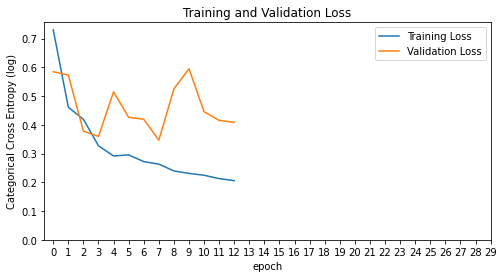

In [265]:
history_plot(model_Inc_FT_history)

Below shows the confusion matrix from the final results of the fine-tuning step. We see that all but one (or 99.1%) of the COVID19 records were classified correctly. For the PNEUMONIA class 92.3% of the records were correctly classified. Most of the incorrectly classified records were wrongly predicted to be NORMAL instead of PNEUMONIA.  The NORMAL class was only properly predicted 69.7% of the time. Taken together, these results indicate that the model as a diagnostic tool is more likely to return false-positives for illnesses than false-negatives, which--as stated earlier--is what we would prefer.

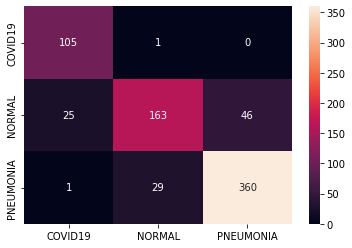

In [267]:
y_pred_Inc_FT = model_Inc_FT.predict(generator_test)
cls_pred_Inc_FT = np.argmax(y_pred_Inc_FT,axis=1)
print_confusion_matrix(cls_pred_Inc_FT)

## ResNet Model

The next framework used for transfer learning was ResNet101 V2. I set up the model in the same manner as the Inception V3 model with a Global Average Pooling layer and a Dropout layer.

### Base Model

In [78]:
base_model_ResNet = ResNet101V2(
    input_shape=(256,256,3), 
    weights='imagenet', 
    include_top=False
    )

base_model_ResNet.trainable = False

### Preprocess

In [79]:
inputs_ResNet = Input(shape=(256, 256,3))

inputs_p_ResNet = ResNet_preprocess(inputs_ResNet)

### Add output layers & Compile

In [270]:
base_ResNet = base_model_ResNet(inputs_p_ResNet, training=False)
GAP_ResNet = GlobalAveragePooling2D()(base_ResNet)
drop_ResNet = Dropout(0.5)(GAP_ResNet)

output_ResNet = Dense(num_classes, activation='softmax')(drop_ResNet)
model_ResNet = Model(inputs_ResNet, output_ResNet)

In [271]:
model_ResNet.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=[f1])

The summary below indicates 42,626,560 parameters in the base model and 6,147 trainable parameters in the final layer. 

In [272]:
model_ResNet.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_6 (Tenso [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_6 (TensorFlo [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 8, 8, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)               

In [124]:
#reset_weights(model_ResNet)

### Fit Model

#### Fit

In [273]:
model_ResNet_history = model_ResNet.fit(
    generator_train, 
    epochs=30, 
    batch_size=128,
    class_weight=class_weight, 
    validation_data=generator_test,
    callbacks=[earlystop_5], 
    verbose=1)

Epoch 1/30
178/178 [==============================] - 3227s 18s/step - loss: 1.0730 - f1: 0.1843 - val_loss: 0.9068 - val_f1: 0.1362
Epoch 2/30
178/178 [==============================] - 3171s 18s/step - loss: 0.9216 - f1: 0.2647 - val_loss: 0.9343 - val_f1: 0.2742
Epoch 3/30
178/178 [==============================] - 3266s 18s/step - loss: 0.8675 - f1: 0.3319 - val_loss: 0.9316 - val_f1: 0.3330
Epoch 4/30
178/178 [==============================] - 3304s 19s/step - loss: 0.8360 - f1: 0.3779 - val_loss: 0.7887 - val_f1: 0.6060
Epoch 5/30
178/178 [==============================] - 3320s 19s/step - loss: 0.8151 - f1: 0.4257 - val_loss: 0.8398 - val_f1: 0.4075
Epoch 6/30
178/178 [==============================] - 3279s 18s/step - loss: 0.7882 - f1: 0.4502 - val_loss: 0.8551 - val_f1: 0.4462
Epoch 7/30
178/178 [==============================] - 3301s 19s/step - loss: 0.7811 - f1: 0.4657 - val_loss: 0.7802 - val_f1: 0.6078
Epoch 8/30
178/178 [==============================] - 3287s 18s/step 

In [274]:
model_ResNet.save('tmp/saved_models/ResNet_1')

INFO:tensorflow:Assets written to: tmp/saved_models/ResNet_1\assets


#### Plots

The learning resulted in a validation loss of 0.6577 and an f1 score of 0.7593. The plot below shows the progress of the loss functions throughout the training. We see that the both loss functions had a larger decrease in the first five epochs than in subsequent ones, however neither plot appears to flatten out indicating that additional epochs may provide an improvement over what was achieved in 30 epochs. 

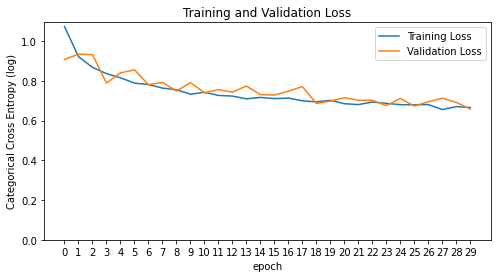

In [275]:
history_plot(model_ResNet_history)

In [276]:
y_pred_ResNet = model_ResNet.predict(generator_test)
cls_pred_ResNet = np.argmax(y_pred_ResNet,axis=1)

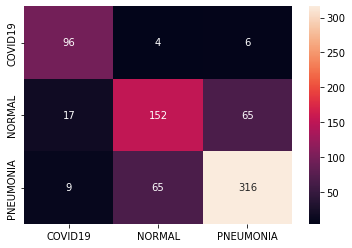

In [277]:
print_confusion_matrix(cls_pred_ResNet)

### Fine-Tune Model

The model was then fine-tuned using the same methodology as with Inception V3.

#### Make Trainable

In [76]:
model_ResNet = load_model('tmp/saved_models/ResNet_1', custom_objects={'f1':f1})

In [75]:
csv_log_ResNet_FT = CSVLogger('training_ResNet_FT.log', separator=',', append=False)

In [80]:
base_model_ResNet.trainable = True

model_ResNet_FT = model_ResNet

model_ResNet_FT.compile(loss='categorical_crossentropy',
                optimizer=Adam(1e-5),
                metrics=[f1])

#### Fit

In [81]:
model_ResNet_FT_history = model_ResNet_FT.fit(
    generator_train, 
    epochs=30, 
    batch_size=128,
    class_weight=class_weight, 
    validation_data=generator_test,
    callbacks=[earlystop_5],
    verbose=1)

Epoch 1/30
178/178 [==============================] - 7217s 41s/step - loss: 0.6072 - f1: 0.6752 - val_loss: 0.5288 - val_f1: 0.7887
Epoch 2/30
178/178 [==============================] - 7036s 40s/step - loss: 0.3930 - f1: 0.8064 - val_loss: 0.3955 - val_f1: 0.8474
Epoch 3/30
178/178 [==============================] - 6848s 38s/step - loss: 0.3061 - f1: 0.8505 - val_loss: 0.3812 - val_f1: 0.8475
Epoch 4/30
178/178 [==============================] - 6681s 38s/step - loss: 0.2936 - f1: 0.8615 - val_loss: 0.4405 - val_f1: 0.8458
Epoch 5/30
178/178 [==============================] - 6641s 37s/step - loss: 0.2257 - f1: 0.8904 - val_loss: 0.3543 - val_f1: 0.8547
Epoch 6/30
178/178 [==============================] - 6532s 37s/step - loss: 0.2116 - f1: 0.8992 - val_loss: 0.3391 - val_f1: 0.8778
Epoch 7/30
178/178 [==============================] - 6551s 37s/step - loss: 0.2140 - f1: 0.9051 - val_loss: 0.4015 - val_f1: 0.8275
Epoch 8/30
178/178 [==============================] - 6559s 37s/step 

In [82]:
model_ResNet_FT.save('tmp/saved_models/ResNet_1_FT')

INFO:tensorflow:Assets written to: tmp/saved_models/ResNet_1_FT\assets


#### Plots

The history chart shows early stopping was triggered. Both training and validation loss continued to decrease until epoch 12 when validation loss had a sharp increase. In subsequent epochs validation loss never fell back to the score it achieved in epoch 11, which indicates the training got to a point where it was overfitting to the training data. The best score achieved was a validation loss of 0.2576 and an f1 score of 0.9052.

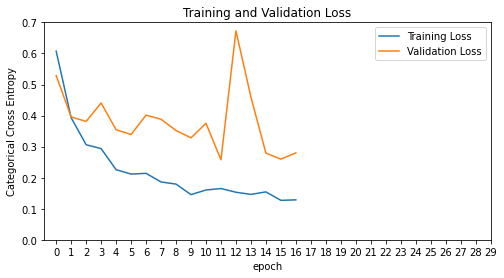

In [83]:
history_plot(model_ResNet_FT_history)

The confusion matrix below shows the model predicted every true positive for the COVID19 class correctly. It predicted 93.3% of the true positives for PNEUMONIA correctly. For the NORMAL class, 81.2% were predicted correctly. These results indicate that the model is more likely to predict false-positives for COVID19 and PNEUMONIA rather than to miss true positives for either. Again, in a clinical setting, one would prefer to have the errors skew more towards false positives than false negatives.

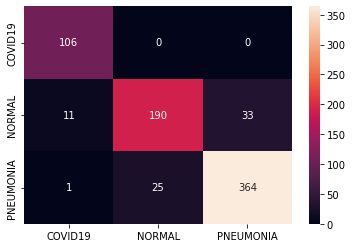

In [84]:
y_pred_ResNet_FT = model_ResNet_FT.predict(generator_test)
cls_pred_ResNet_FT = np.argmax(y_pred_ResNet_FT,axis=1)
print_confusion_matrix(cls_pred_ResNet_FT)

## Conclusion

Comparing the performance of the two models, the ResNet101 V2 model had the lowest validation loss and the highest f1 score, though the performance Inception V3 was only slightly worse than that of ResNet101 V2. The ResNet model had recall scores of 100% and 93.3% for the COVID19 and PNEUMONIA classes respectively, indicating a low likelihood of the model predicting a false-negative of either class. The precision of the predictions was 89.8% and 91.7% respectively. This indicates that there is roughly a 10% likelihood of returning false-positive predictions for both classes. 

In a clinical setting, one would want to err on the side of providing a diagnosis in instances where the patient is normal than the side of not providing a diagnosis when the patient has a malady such as the classes in these models. Therefore we would give more weight to false-negatives than false-positives in assessing how much error we are comfortable with. To that end, this model may be quite useful for diagnosing COVID19, but the false-negatives associated with the PNEUMONIA class may need to be reduced in order for the model to be used for that diagnosis.